# Lab 3: Line Following

In previous lab sessions, you have:
- Seen the standard Arduino sketch, which has the structure of setup() and loop() routines.
- Experimented with Arduino Example sketches
- Uploaded sketches to your robot.
- Experimented with Serial commands to view debug output from your code.
- Controlled the power of the two motors with analogWrite()

In this labsheet we will learn to operate the sensors for line detection.  On the 3Pi+ there are 5 of sensors facing toward the ground surface. These are visible beneath the robot, as annotated in the following image:

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0053_21_22/blob/main/images/3PI_BottomAnnotated.png?raw=true">
<br>
</p>


For basic operation of following a line, the 3 central sensors are most useful.  The exercises in this labsheet omit the left-most and right-most sensors to simplify the learning process and tuition. After this labsheet, you might want to adapt your code to include these two further sensors.







# 3Pi+ Line Sensors, Theory of Operation



<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0053_21_22/blob/main/images/Webots_GSReflectance.png?raw=true">
<br>
</p>

The line following sensors operate by transmitting a beam of infra-red line and sensing the intensity of the reflection.  These are labelled `GS0`, `GS1` and `GS2` in the above illustration ("ground sensor"), and on the 3PI+ circuit board you can see them labelled as `DN1`, `DN2`, `DN3`, `DN4`,  and `DN5`.  The **`transducer`** in this sensor is a photo-transistor - a transistor whose operation is effected by light.  

Intuitively, we might expect that we can use the **`analog-to-digital converter`** (**`ADC`**) inside the 3Pi+ 32u4 microcontroller to measure the intensity of the reflected light.  That would be one possible way to design the electronic circuit, and an example of a sensor to operate in this way is <a href="https://www.pololu.com/product/2458">available here</a>.  The line sensors on the 3Pi+ do not work this way.  

The line sensors and bump sensors operate under the same principle.  The circuit for the bump sensor is easier to review:

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0053_21_22/blob/main/images/3PI_BumpSchematic.png?raw=true">
<br>
</p>

In the above schematic for the 3Pi+ bump sensors  (page 3, in the <a href="https://www.pololu.com/file/0J1790/3pi-plus-32u4-control-board-schematic.pdf">electronic schematic</a>), we can see 3 principle circuits.  On the far left are infra-red `Light Emitting Diodes` (`LEDs`).  These are enabled or disabled in software.  If they are disabled, the sensor will be behaving under `ambient light` conditions - whatever IR light exists in your working environment.  The two circuit components on the right are the detecting circuits.  The general form of this circuit is repeated for the 5 ground facing sensors.  

The detecting circuits utilise a photo-transistor in a small electronic circuit to control the rate of charging and discharging of a capacitor.  The photo-transistor (labelled `Q10` and `Q11` above) is the **`transducer`** in the sensor, the element converting energy from one form to another - the light (photon energy) exposure attenuates the (electron energy) activation of the photo-transistor.  In this circuit, we can imagine that the photo-transistor is restricting the electron flow of the circuit to varying degrees depending on the light conditions.  It might be useful to think of a capacitor (labelled `C53` an `C54` above) as a very small battery which can be charged and discharged quickly.  

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0053_21_22/blob/main/images/3PI_IRDischarge.png?raw=true">
<br>
</p>

Varying the IR light on the photo-transistor will change the time it takes for the capacitor to discharge.  Whilst the discharge of the capacitor is a continuous analog signal, a `digitalRead()` will register either `HIGH` or `LOW` depending on the voltage of the capacitor with respect to a logic threshold voltage.  We always expect digital logic to work in this way, and it is a characteristic which makes digital electronic circuits robust to signal noise.  

In the above illustration, we can observe how a slower discharge means more time will elapse before `digitalRead()` registers a `LOW` state.  Therefore, the exposure of the photo-transistor to IR light is determined by the `time` taken for the capacitor discharge to transition from logic `HIGH` to logic `LOW`.  

This might seem unnecessarily complicated.  A reasonable question would be, "why not use the ADC?" or, "why measure the time of discharge?".  The answer is that microcontrollers typically have a small number of `ADC` **`channels`**, or pins to take analog measurements.  The 3Pi+ has been designed to use every single pin available on the 32u4 microcontroller, and so some compromises were necessary in the design.  By measuring the time taken for a capacitor discharge, a general purpose `digital pin` (normally binary, 0 or 1) can be instead be used, and yet a continuous measurement still taken (represented as time).  


### Operation Steps

From the above (and a few more small details in the <a href="https://www.pololu.com/docs/0J83/5.5">documentation</a>), we can summarise the following programming instructions required to utilise the infra-red sensors to measure IR light reflected from the 3Pi+ work surface:
1. Set the infra-red LEDs to be enabled, to transmit infra-red light to reflect off the work surface.
2. Set the sensor measurement pin to an `OUTPUT` with state `HIGH`.
3. Wait for 10microseconds for the capacitor to charge to full.
4. Set the sensor measurement pin to an `INPUT` with high impedance.
5. Recording the passage of time, wait for `digitalRead()` to change to `LOW` whlist the capacitor discharges.
6. Once `digitalRead()` has change to `LOW`, record the elapsed time as the sensor reading.  

### A Final Detail:

The design of the 3Pi+ uses some techinques to re-use digital pins for different functions.  The line sensor and the bumpers both require IR LEDs to be enabled, but it is desirable that their respective IR light transmission does not interfere with each other.  A single 32u4 `GPIO` pin has been used to enable and disable the IR LEDs for line sensors and bump sensors independently:

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0053_21_22/blob/main/images/3PI_LineSensorEMIT.png?raw=true">
<br>
</p>

In the circuit extract above (<a href="https://www.pololu.com/file/0J1790/3pi-plus-32u4-control-board-schematic.pdf">electronic schematic</a>) the IR LED circuit for the line sensor and bump sensor are placed next to each other.
- On the left, we see that the `EMIT` connection is used to `sink` (act as ground, 0v) the supply from 5v through the IR LEDs.  This is achieved in software by setting the `EMIT` pin to an `OUTPUT` with `LOW` output.  
- On the right, we see that the `EMIT` connection is used to `source` 5v through the IR LEDs to the circuit ground, 0v.  This is  achieved in software by setting the `EMIT` pin to an `OUTPUT` with `HIGH` output.  

This circuit works because diodes (including light emitting diodes) can only function in one direction of an electronic circuit.  

To disable the IR LEDs for both the line sensor and the bump sensor, we use the 32u4 to turn the `EMIT` pin into an `INPUT`.  This neither provides 5v or grounds the circuit properly, and the IR LEDs cannot activate properly.






## Exercise 1: Setup

To begin with, put aside your previous work with the 3Pi+.  When we are first developing for new hardware, we want to keep the process as simple and as error free as possible.  In this labsheet, we will only work with the 3 central line sensors beneath the 3Pi+ robot:

1. Save your previous work, and start a new sketch (source code file).  Give this a useful name, such as "lineSensorTest", or "Labsheet3".

2. Use the 3Pi+ <a href="https://www.pololu.com/docs/0J83/5.9">documentation</a> to find and note down the correct 32u4 `GPIO` pins we will need to operate the 3 central line sensors.  You will want to use pin numbers given in the column labelled `Arduino pin names`, because we are working within the Arduino IDE: 
  - `EMIT` pin.
  - input pins for the 3 central sensors labelled `DN2`, `DN3`, and `DN4`.

3. Use the standard Arduino template of `setup()` and `loop()`.  If you are unsure, you could open the Arduino IDE example "Blink" and adjust the code therein.  At the top of your file in `global scope`:
  - Add `#define` statements to create references for the pins you have found above.
  - Use meaningful names, such as "LS_LEFT_IN_PIN", "LS_CENTRE_IN_PIN", "LS_RIGHT_IN_PIN" (where LS represents "line sensor").

4. Add code to `setup()` to set:
  - EMIT pin mode as an `OUTPUT`.
  - The 3 line sensor input pins mode as `INPUT`
  - Add `Serial` functionality to help you to later debug your code.  Add a print command to transmit to you that the Arduino has completed setup.  
  - You can refer back to previous work to find examples of all the built-in functions you require.

5. Thinking ahead, should the `EMIT` pin be set `HIGH`, or `LOW` to enable the IR LEDs for the line sensors?
  - either use the documentation, or review the circuit schematic and discussion above.

# Detailed Operation

In previous work you will have used the built-in functions `delay()` and `delayMicroseconds()`.  These built-in functions are using a hardware peripheral called a `Timer` built into the microcontroller to count the passage of time.  We will investigate a `Timer` in detail in a later labsheet.  For now, we will just investigate further utility immediately available.  We can access this same underlying resource with the built-in functions:
- `millis()`, <a href="https://www.arduino.cc/reference/en/language/functions/time/millis/">Arduino Reference</a>
- `micros()`, <a href="https://www.arduino.cc/reference/en/language/functions/time/micros/">Arduino Reference</a>

The above functions `return` a count of milliseconds and microseconds elapsed since the 3Pi+ was powered-on.  These count values are automatically incrementing in the background whilst your code is operating.  These count values are not the actual time-of-day, as we know it.  When the 3Pi+ is reset or power-cycled (on/off/on), the count is reset from 0.

To maximise the utility of this functionality, both functions store the count in a `variable type` declared as **`unsigned long`** (<a href="https://www.arduino.cc/reference/en/language/variables/data-types/unsignedlong/">Arduino Reference</a>).  The reference tells us:
> Unsigned long variables are extended size variables for number storage, and store 32 bits (4 bytes). Unlike standard longs unsigned longs won’t store negative numbers, making their range from 0 to 4,294,967,295 (2^32 - 1).

This means that:
- `millis()` will count up to 4,294,967,295 milliseconds, or 49.710 days, before the variable storing the count **`overflows`** and starts again from 0.
- `micros`() will count up to 4,294,967,295 microseconds, or 1.19 hours, before the variable storing the count **`overflows`** and starts again from 0.

It is interesting to consider that all (designers of digital) robots will encounter this problem of "time overflowing" in one form or another.  Fortunately, for our studies, we do not expect the 3PI+ robot to operate for more than a few minutes at a time.  

We will use `micros()` to calculate how much time is taken for the line sensor to register as logic `LOW`, providing our sensor measurement.  



## Calculating Elapsed Time: Variable Types, Typecasting

In C, we have to take care when using different variable types within calculations or conditional statements.  An `unsigned long` provides a perfect example.  As noted above, an `unsigned long` is `returned` by `millis()` and `micros()` because it will store very large positive-only numbers.  It helps to remember that variables take up a reserved amount of space in computer memory.  We learnt that an `unsigned long` represents values across 32-bits, or 4 bytes (4 sets of 8 bits), or reserved memory.

Within our sensor operation, we are anticipating calculating how much time has elapsed.  We can imagine a circumstance where we record the current time into an `unsigned long`, and then for one reason or another (just for the sake of an example), we then assign this value into an `integer` variable:

```c 
unsigned long current_time;
int my_integer;
current_time = micros();
my_integer = current_time;
```

If my_integer is later used, the above code is likely to cause an `intermittent error`, which is one of the worst types of bugs to have in code.   An `intermittent error` means that sometimes your code works as you expect, and sometimes it doesn't - and you would need to hunt for the cause.  The code above looks like the correct `syntax`, and it might even make sense in terms of logical operation.  Often, you'll need a patient friend, tutor or <a href="https://en.wikipedia.org/wiki/Rubber_duck_debugging">rubber duck</a> to help you find these bugs.  

An integer (<a href="https://www.arduino.cc/reference/en/language/variables/data-types/int/">Arduino Reference</a>) in Arduino is defined as:
> ...an int stores a 16-bit (2-byte) value. This yields a range of -32,768 to 32,767 (minimum value of -2^15 and a maximum value of (2^15) - 1).

Here we see that an `int` only reserves 16 bits of memory, and then utilises that to represent both positive and negative values.  Hopefully, you have the question, "how would a large 32-bit unsigned number be stored into a signed 16-bit numnber?".  This is the source of our intermittent error.  On Arduino, smaller values would be (converted and) stored correctly.  However, once the upper limit of an `integer` is reached, the value of the `unsigned long` will defy our normal expectations:

```c
unsigned long my_ul;
int my_int;

// + limit of an int
ul = 32767;
my_int = ul;
Serial.println( my_int ); // Prints 32767 correctly.

// just "1" over a +int, but huge error
// Might cause robot to zoom away :)
ul = 32768;
my_int = ul;
Serial.println( my_int ); // Prints -32767, incorrect?
```
In the above, we see the cause of our (imagined example of an) intermittent error.  Arguably, the microcontroller is doing exactly what it should, and the source of the error would be you, the fallible human programmer.  

As a rule of thumb, it is important to:
- respect the `return type` of any function used, so assign the return value into an apppropriate variable
- perform calculations within the same variable type, or assign a variable between types when the value is known to be safe to do so.

Our requirement to calculate elapsed time provides another good example.  Here is an example of code that might work, if you're lucky:
```c
// Please note, this is an example of poor code.

unsigned long start_time;
float elapsed_time;

start_time = micros();

// Feeling lazy, will store current time
// into "elapsed_time" for now. 
//
// Bug: this is imlicitely casting an 
// unsigned long into a float variable :( 
// Unexpected behavior with large values!
elapsed_time = micros();

// Calculate elapsed time
// Here, a portion of our calculation is
// with a float variable against the return
// type of micros() unsigned long
// Bug: So what type is the calculation in?
elapsed_time = elapsed_time - micros();

```
<p><br></p>

A better example is below:

```c
unsigned long start_t;
unsigned long end_t;
unsigned long d_t;
int result;

// Get starting time
start_t = micros();

// ...

// Get end time
end_t = micros();

// Calculate difference
// Note, we expect dt to now be a small
// value, because we subtract two potentially
// large values.  Left-hand and right-hand
// of this calculation have matching types.
dt = start_t - end_t;

// We can typecast and store a small value
// into an int (or other variable type).
result = (int)dt;

```








## Example Operation


Remembering the theory of our line sensor operation, we can utilise `micros()` to calculate how much time has elapsed whilst the capacitor was discharging:

```c
// ...

// An example of line sensor operation
void loop() {

  // Charge capacitor by setting input pin
  // temporarily to output and HIGH
  pinMode( LS_LEFT_IN_PIN, OUTPUT );
  digitalWrite( LS_LEFT_IN_PIN, HIGH );

  // Tiny delay for capacitor to charge.
  delayMicroseconds(10);

  //  Turn input pin back to an input
  pinMode( LS_LEFT_IN_PIN, INPUT );

  // Begin measurement of time in 
  // microseconds
  unsigned long start_time;
  unsigned long end_time;
  start_time = micros();

  // Stay in a loop whilst the capacitor
  // is still registering as "HIGH".
  while( digitalRead( LS_LEFT_IN_PIN ) == HIGH ) {
    // Do nothing
  }

  // record end time
  end_time = micros();

  // Calculate elapsed time
  unsigned long elapsed_time;
  elapsed_time = end_time - start_time;

  // Print output.
  Serial.print("Left line sensor: " );
  Serial.print( elapsed_time );
  Serial.print("\n");

  // Delay, to read our sensor slowly
  // but consistently.
  delay(100);


}
```


## Exerise 2: Sensor Validation

An important step is to validate that the example above demonstrates a working sensor operation:

1. The above example given in `loop()` has the following assumptions you need to address in your own code:
  - Ensure that you have completed your `setup()` routine to set the relevant `GPIO` pins into a good initial state.
  - The example assumes that the IR LEDs were enabled (turned-on) within `setup()`.  What is the state of your IR LEDs?

2. Upload your code to the 3Pi+ and validate that you see a difference in the sensor reading between different surfaces.  
  - Use the Serial Monitor and check the reported elapsed time value.
  - Use the black vinyl tape to create a dark surface  - this will also be the surface of line your 3Pi+ will need to follow.
  - Quickly explore different surfaces to build your intuition, examples include:
    - a page with printed text.
    - different colour surfaces.
    - glossy and matte surfaces.
    - you can <a href="https://github.com/paulodowd/EMATM0053_21_22/tree/main/PrintableSheets">download and print</a> a grey-scale test sheet from Github.
    
3. Note down the smallest time reported and the largest time reported:
  - How do these correspond to your different surfaces?
  - How many milliseconds is the longest time reported? 

4. Inspect the timing values when the IR LEDs are switched off.
  - Remember: to switch of the IR LEDs, you must set the `EMIT` pin to mode `INPUT`.

4. Use the grey-scale test sheet, or construct your own varied black-to-white surface, and record the results into the code cell below to plot a graph:
  - how would you intepret the shape of the line, the **`sensor response`**.
  - is your sensor consistently reliable across all surfaces?
    
  

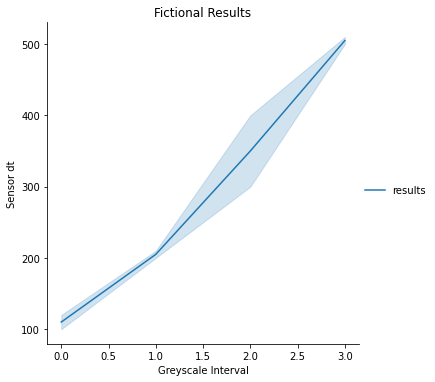

In [25]:
#
# An example of using Python, Seaborn and
# Pandas to plot data into a Boxplot. 

# We use numpy to create an array of values
import numpy as np

# We will use a library called Seaborn to 
# make our box plot for us, so we import it.
import seaborn as sns

# To graph more than one dataset is a little 
# complicated.  We need to format the
# data into 'dataframes'.  We use the pandas
# library to do this for us.  Import pandas:
import pandas as pd

# Add your measurements into the array
# like the following.  
# [ <interval>, <measurement> ]
results = np.array( 
          [[ 0, 100 ],
           [ 0, 120 ],
           [ 1, 200 ],
           [ 1, 210 ],
           [ 2, 300 ],
           [ 2, 400 ],
           [ 3, 500 ],
           [ 3, 510 ] ] )

# Reformat the data using pandas
results = {"results": pd.Series(results[:,1], index=results[:,0]) }

dataframe = pd.DataFrame( results );


# We can now plot both datasets at the same time.
# Note, data=combined!
plot = sns.relplot(data=dataframe, kind="line")
plot.set(xlabel ="Greyscale Interval", ylabel = "Sensor dt (microseconds)", title ='Fictional Results')

## Exercise 3: Improving the Example

The example provided has significant room for improvement.  The below code extract is the part of the routine that waits for the `digitalRead()` measurement to go `LOW`.  Currently, in extreme cases the sensor may take approximately 2400 microseconds (2.4milliseconds) to complete on a very black surface.  Furthermore, an ambient light measurement can exceed 5000microseconds (5millisceonds).  In both cases, millisecond durations are quite long and undesirable. 

```c

  // Begin measurement of time in 
  // microseconds
  unsigned long start_time;
  unsigned long end_time;
  start_time = micros();
 
  // Stay in a loop whilst the capacitor
  // is still registering as "HIGH".
  while( digitalRead( LS_LEFT_IN_PIN ) == HIGH ) {
    // Do nothing
  }
 
  // record end time
  end_time = micros();
 
  // Calculate elapsed time
  unsigned long elapsed_time;
  elapsed_time = end_time - start_time;

```

In the above code extract, we can see that the `while()` loop is very inefficient, not executing any instructions beyond checking the `conditional statement`.  This `while()` loop could also run for an indeterminate (unknown) amount of time if there was an error or bug somewhere - this is not very safe code.  

1. Edit the `while()` loop in the above code extract so that it will `abort` (stop) a reading if it is taking too long to complete:
  - use a variable to set a `time out` value, or maximum time value.
  - consider placing this `time out` value as a `#define` value at the top of your program, so that it can easily and quickly be changed in the future.
  - use the `while()` conditional statement to check the elapsed time against your `time out` value.

2. What is a useful `time out` value?  Inspect the graph you have plot in Exercise 2.5 to justify your decision.  



<table><tr>
<td><img src="https://a.pololu-files.com/picture/0J9303.1200.jpg?ef05b47c0d9a602458f464a7782348f3"/></td>
<td><img src="https://a.pololu-files.com/picture/0J8950.1200.png?d7c8996705fe7a021a292596ce045770"/> </td>
    </tr>
    </table>

When the sensor is above a reflective surface (e.g. white piece of paper for example), the light from the IR LED will be reflected strongly, turning on the photo-transistor and pulling the output voltage towards ground. If, on the other hand, the sensor is above a low-reflective surface (black tape for example), the photo-transistor will mostly be turned off, and the output voltage will be pulled towards $V_{in}$(5V in our case). 

We can measure the voltage at the output by connecting the output signal to one of the Analog pins on the Romi control board. For more information about the QTR-3A, you can check [here](https://www.pololu.com/product/4443) or [here](https://www.pololu.com/docs/pdf/0J13/QTR_application_note.pdf). The difference in voltage between light and dark surfaces will depend on how far the sensor is from the surface.


<pre><br><br><br></pre>

<pre><br><br><br></pre>

# Exercise 2: Building a Class

A `class` is a way to group code together.  It helps to make writing code more efficient.  It also helps with the readability of code.  These two things together should make your code easier to debug.  At this point, you should have written a few functions and also used some global variables.  We can think of a class as way of containing these same techniques within itself.

When a class is used, it is clear what variables are associated to which parts of a program.  A class is usually written to provide it's own set of functions.  In general, when a class is used, it will help to prevent a huge number of variables and functions cluttering up the main part of your program.  When a class is created well it can be used multiple times, providing 'copies' of the same code for different problems.  You can almost think of a class as a "mini-program", however you must make calls to it and control its execution from your main program.

A class in Arduino has the following basic structure which is mandatory:

```C++
class myClassName_c {     // This encapsulates (contains) your class, and sets the class-name.
  public:
    
      // The constructor function has the same name as the class
      // typename, and works a bit like setup().
      myClassName_c() {       

      }

};      // The end of the class encapsulation.
```


It is important that you consider the above as just a general template for a class. 

In your main code, you can create multiple copies of this class.  For example:

```C++
myClassName_c copy1;
myClassName_c copy2;
myClassName_c copy3;

void setup() {

}

void loop() {

}
```

Notice in the above, that `copy1` `copy2` and `copy3` all share `myClassName_c` as a type.  Recall that, when we write:
```C++
int my_int;
```

We are telling the arduino to create a space in memory to store an integer number.  `int` is the type, and `my_int` is the name we have decided to use to access the space created.   

Using classes follows the same format.  We are asking the Arduino to create a space in memory to store all of the code contained within our class (`myClassName_c`), and that we wish to access it via the names `copy1`, `copy2` and `copy3`.  Because we are giving them 3 different names, we are creating 3 different spaces each with the same format.

Before going any further, the template declaration of a class uses the typename `myClassName_c`.  The underscore-c `_c` is not a necessary part of declaring a class typename.  However you will notice that if you use a `typedef`, `struct`, `union` or `class` within Arduino, it doesn't receive any syntax highlighting (it is not coloured like a variable type for you).  **In order to make your code easier to debug, it is useful to place a `_c` after a class typename to remind yourself that you are looking at and working with a class.  This small effort will save you a lot of time debugging.**  Similarly, you might use `_s` for a struct, a `_u` for union, a `_t` for typedef.  We do not cover unions, typedef, or struct on this course.

Within a class, we can store variables and write functions which will only exist for an individual copy of the class.  For example:
```C++
class myClassName_c {     // This encapsulates (contains) your class, and sets the name.

  public:
      
      // Variables, kept within your class instance.
      int   an_int;           // Lets keep an integer
      float a_float;          // and a float.

      // Function prototypes - a useful list of functions available in your class..
      float returnMyFloat();  // A function to report a_float.
      int returnMyInt();    // a function to report an_int.
  
      
      // The constructor function has the same name as the class
      // typename, and works a bit like setup(). 
      myClassName_c() {       

          // Similar to setup(), we initialisev variables.
         an_int  = 0;
         a_float = 0;

      }

};

// A function belonging to myClassName
float myClassName_c::returnMyFloat() {
  return a_float;
}

// A function belonging to myClassName
int myClassName_c::returnMyInt() {
  return an_int;
}
```

Note in the above that, the variables and functions are declared within the class - all the data is kept inside the class encapsulation, the template we are creating.  

We have written the functions outside of the class, using the syntax `myClassName::returnMyFloat() { `.  The functions you write outside the class must be prefixed with the name of the class in this way, and the function name must match the declaration set within the class. 

Once we have defined a class in this way, we can use it very easily from our main program.  For example:
```C++
myClassName_c copy1;
myClassName_c copy2;
myClassName_c copy3;

void setup() {
  copy1.an_int = 10;   // Perform a write to the variable within copy1.
  copy2.a_float = 0.6; // Perform a write to the variable within copy2.
}

void loop() {

  copy1.an_int = 20;      // A write operation to the variable inside copy1.
  copy1.returnMyInt();    // A function call working from within copy1
  copy2.returnMyFloat();  // A function call working from within copy2
  
}
```

Notice that, every time we are using the class, we use the name we decided to call our class instance  (`copy1`, `copy2` or `copy3`) and a `.` (dot).  


If we are accessing a variable inside a class, we use the name of the variable following the dot, like:
```C++
  copy1.an_int = 20;      // A write operation to the variable inside copy1.
  int a = copy1.an_int;   // A read operation from the variable inside copy1.
```

If we are calling a function inside a class, we use the name of the function after the dot, like:  

```C++
  copy1.returnMyInt();    // A function call working from within copy1, 
                          // not storing returned value.

  float b = copy2.returnMyFloat();  // A function call working from within copy2,
                                    // storing returned value to variable "b"
```


Functions within a class can also take arguments (variables passed into the function).  If you look at the lineSensor.h class from the code provided, you'll see that the class `LineSensor_c` has the constructor:

```C++
    // Required function, class Constructor: 
    // Saves the pin passed in as argument and sets to input
    lineSensor_c(int line_pin) {
      pin = line_pin;
      pinMode(pin, INPUT);
    }
```

Here, `pin` is a variable declared within the class.  We are assigning `line_pin` into pin, meaning that the class will store (e.g. remember) which pin you told it to work from.  The next line sets the pin mode, because we are using this class to operate one of the sensors attached to either A2,A3 or A4.  

If you look at the top of the main program (Romi) you should see:

```C++
// You may need to change these depending on how you wire
// in your line sensor.
#define LINE_LEFT_PIN A4 //Pin for the left line sensor
#define LINE_CENTRE_PIN A3 //Pin for the centre line sensor
#define LINE_RIGHT_PIN A2 //Pin for the right line sensor

lineSensor_c line_left(LINE_LEFT_PIN); //Create a line sensor object for the left sensor
lineSensor_c line_centre(LINE_CENTRE_PIN); //Create a line sensor object for the centre sensor
lineSensor_c line_right(LINE_RIGHT_PIN); //Create a line sensor object for the right sensor
```

Here, we are creating 3 copies of the LineSensor class, named `line_left`, `line_centre` and `line_right` respectively.  When we create these class instances, we also have to pass in the pin - because it is defined this way in the constructor written within LineSensor.h.  We use a `#define` statement to make changing these values quiker and more readable.  Whilst the class template is the same, each of these class instances will now work from a different pin.

When you build up the class, you will make calls to these class instances.  For example, within your setup(), you will need to do something like:

```C++
 // Calibrate the three line sensors.
  line_left.calibrate();
  line_centre.calibrate():
  line_right.calibrate();
```



    
## Task:

### Getting Started

You can find a partially complete `class` for your line sensor on github.  It is recommended to download the code stub which has class templates created for you in seperate files. These should appear as tabs within the Arduino IDE.
- Add a new function to the lineSensor_c class to return the result of an `analogRead()`
- Declare 3 instances of the lineSensor_c class in your main code. 
    - Make sure that each instance receives a different pin for each of the small IR detectors on the line sensor (`A4`, `A3`, `A2`).
    - Use `Serial.print()` within `loop()` to inspect the values reported by your line sensor class.  


### Calibrating for Bias

You should notice that when your line sensor is over white paper, the 3 IR detectors report slightly different values.  In theory, we want the left, centre and right IR detectors to influence the turning behaviour of the robot equally, left to right.  Therefore, any bias might cause the robot to drift one way or the other.  We can remove this bias to make the sensor easier to work with.

- Write a calibration routine for the IR sensor.  
    - Your calibration routine should compensate for any bias in each individual sensor signal.
    - You'll need to create variables within the class to store your bias reading.
    - The simplest way to calibrate is to construct a mean (average) value whilst the IR detector is over a white surface.  When we then take later readings, we can subtract this average (the bias) from our reading. 
    - **Hint:** Be careful of variable over flow.  If you store something like 100 sensor readings into a float it may overflow.  It can be better to store, on each iteration, the current reading divided by the total number of samples - e.g., accumulating the fractional values
    - The way floating point numbers are stored computationally is really clever and interesting, <a href="https://youtu.be/PZRI1IfStY0">check out this video!</a>

    - **Hint:** Be careful of type conversion. If you store sensor readings into an int, a division operator or multiplication by a fraction may return 0.
    - **Hint:** In order for our calibration routine to run correctly, the Romi should remain stay with all sensors on a white surface. It's a good idea to add a beep to the end of your calibration routine so you know when your calibration is complete.
- Write and test a new function which returns the `analogRead()` value minus your calibrated bias value.  A good name would be readCalibrated().
- Adjust your main code so that:
    - When your robot powers up, `setup()` calls the calibrate routine for each of your 3 IR detectors on the line sensor.
    - Your Romi then reports via Serial the calibrated values from your sensor.

### Going further (optional)

If you are observant, you may notice that once you have completed your calibration, your Romi may later report negative values from the sensor, even though we would expect calibration to fix the 'white surface' value to 0.  This is largely due to changes in the environment.  As your robot travels:
- the ambient light will change, effecting the sensor reading.
- the Romi chassis will move, altering the distance to the surface.
- the stablity of the power supply for your Romi may vary, effecting readings.

A technique to mitigate such factors may be to continuously calibrate the sensor during the operation of you Romi, but this requires careful consideration.

In the above task, we also only corrected for bias over a white surface.  There are other factors.  For instance:
 - the minimum value reported by the sensor.
 - the maximum value reported by the sensor.
 - the slope of the line between minimum and maximum.
 - the linearity of the reponse.
 
These are interesting characteristics to explore - however we can consider that there is a trade-off between the time we spend developing robust solutions, versus the measurable performance of the robotic system.  Two skills to develop through practice with robotic systems are:
- to identify when a solution is 'good enough', often in terms of it being robust and reliable in performance.  
- to identify whether artefacts (such as small negative values as discussed above) actually effect performance or not.


<pre><br><br><br></pre>

# Exercise 3: Bang-Bang controller

In this exercise, we will implement a simple Bang-Bang controller to follow a line. A Bang-Bang controller selects from a limited range of control outputs (Usually two, but in this case three). The control logic (the decision the robot will make) is as follows:

- Line under sensor 1 -> Turn Right
- Line under sensor 2 -> Go Straight
- Line under sensor 3 -> Turn left

The output from an individual reflectance sensor will be a voltage between 0 and $V_{in}$. This will be read by the Analog to Digital Converter (ADC) in the Romi's Atmel 32u4 and converted to an integer between 0 and 1023. We must convert these numbers into something which is meaningful to us. The simplest way to do this is to convert the output to a binary signal (telling us whether a particular sensor is over a line or not) by applying a threshold. 

## Task 1:
- Determine an appropriate threshold for this signal. 
- Start by repeatedly printing the (calibrated) value of the sensor and see how it changes as you move the sensor on and off a line. 
- Adapt your code to print to the Serial port whenever a sensor is over a line. 
- Repeat this process for the other two sensors. Your system should now print whenever a sensor believes it is over a line. Briefly evaluate the performance of your solution to be correct and reliable.


## Task 2:

- Write a function "BangBang()" which implements the Bang-bang controller. Make a call to this function from `loop()`. 
- BangBang() will need if() statements to decide how to move your motors given which sensor threshold is crossed.  
- BangBang() should be called repeatedly by the main loop - avoid using blocking calls such as `while()` and `for()`.  

**Hint:** It can be useful to ignore forward movement to begin with.  Instead, check that your robot turns toward the line and centres well first.  A common error is that the robot is actually turning away from the line, but still manages to work "somtimes".

**Hint:** Be aware that high motor power values will cause your robot to move very quickly - and so the sensor may completely skip over the line before it can take a reading.  Therefore, start with low power values for your motors, and then increase these towards a more desirable performance.

**Hint:** You will need to make a few decisions when implementing this approach. You will need a threshold for evaluating which sensor the line is under, and also decide appropriate motor power values for forward and turning. You will also need to consider what your controller should do if it detects a line under multiple sensors (or even none).

**Hint:** In terms of behaviour, how could the following two pieces of code differ?  Think especially in terms of unwanted behaviour concerning the final value of the variable **a**.  

```C++
/* Example 1 */

int a = 0;
if( condition1 == true ) {
  a = 1;
} 
if( condition2 == true ) {
  a = 2;
}
if( condition3 == true ) {
  a = 3;
}


/* Example 2 */

int a = 0;
if( condition1 == true ) {
  a = 1;
} else if( condition2 == true ) {
  a = 2;
} else if( condition3 == true ) {
  a = 3;
} else {
  
}
```

## Task 4:
Evaluate the performance of the controller. Use a range of lines to test performance. 
- Which characteristics of line does it struggle with?  When does it simply fail?
- What could be good metrics for measuring line following performance? 
- How does the performance vary as you alter the parameters discussed above?

<br><br><br><br>

# Exercise 4: Weighted Line Sensing

The simple thresholding method we used in Exercise 3 has two big drawbacks
- it is very sensitive to our choice of where we put the threshold. 
- it throws away a lot of useful information by just assessing for above or below a threshold.

A more elegant approach is to think of the output of each sensor as a likelihood that the sensor is over a line. We can then use these likelihoods to calculate a most probable location for the line (relative to the sensor).  This can give us a continuous signal of line position, rather than a binary signal.



One method to get the desired measurement is to:


1) Calculate the total magnitude of the calibrated sensor readings: $I_{total} = I_{left} + I_{centre} + I_{right}$

2) Calculate each sensor reading as proportional to the total: $$P_i = \frac{I_{i}}{I_{total}}$$ where $$i = [ left, centre, right]$$

3) Calculate the final output Measurement as $$M = ( P_{left} - P_{right} )$$



Using this method, M should produce a value in the range `[ -1 : +1 ]`, which we could intepret as `go left` or `go right`, depending on how your sensor is wired up.  Each sensor will return a whole number value between [ 0 : 1023 ] from `analogRead()` or your calibrated read function.  Because we are going to operate a division and work with fractions, it is advisable to use a `float` type variable in your code.



## Task 1:
Write code for your Romi to perform the above calculations from its line sensor readings.  
- Print the output over Serial and verify it is correct by moving the Romi by hand.  
- Check to see if the Measurement values towards -1 occur when the line moves to the left, and towards +1 when the line moves to the right.  You could reverse this left/right relationship if you wish.  What makes intuitive sense to you?
- Check that you receive values tending towards 0 when the line is centred under the sensor.
- **Hint**: analogRead() returns a value of the type `int`.  We know that an `int` cannot store a fraction (e.g. 0.00512).  If analogRead(A2) returns 500, what value will be stored in the variable `result`?  Why?

<pre>
<font color="#00979c">float</font> <font color="#000000">result</font> <font color="#434f54">=</font> <font color="#d35400">analogRead</font><font color="#000000">(</font><font color="#000000">A2</font><font color="#000000">)</font> <font color="#434f54">&#47;</font> <font color="#000000">1000</font><font color="#000000">;</font>

</pre>

- **Hint:** You will spend less time debugging your code if you break the above calculation down into many individual steps.  Always make sure you store values into the appropriate `variable type` before you conduct arithmatic.  


## Task 2:
Update your BangBang() function to utilist your new Line Measurement value.
- Note that, when your line measurement equals 0, you must instruct your Romi to drive fowards.

## Task 3:
Our Line Measurement (`M`) is a value between [-1 : +1 ].  We can use this value to instead scale the power of the left and right motor.  This would have the effect of providing a proportional response of power in relation to how strong the value of the measurement `M` is.  Simply put:

$$Power_{max} = 100$$
$$Power_{left} = M * Power_{max} * +1$$
$$Power_{right} = M * Power_{max} * -1$$

In the above equation, we have the addition of a `*+1` or `*-1`.  Why is this?

Using the above equation, if our measurement `M` was +0.67:

$$Power_{left} = 67$$  
$$Power_{right} = -67$$

- Save a copy of your BangBang() code.  Now write a new function that implements the above method.  Give your new function a name that makes sense to you.
- **Note:** the maximum power of 100 is given just as an example.  
- We multiply the left by the +1 constant, and the right by a -1 constant - why is this?
- Implement this code for your Romi.  Check that the turning direction is correct.  Fix it if not.
- With this solution, what happens when your Romi is centred on the line?  How can you bias the solution to always move forwards?

**Hint**: When we are using M to scale our motor power, beware of high motor power values.  These can cause very sudden motion, causing the sensor to skip over the line without taking a reading.  It can be better to limit the minimum and maximum motor power values scaled by M.

**Hint**: Remember that `analogWrite()` only operates properly with a whole number value between [ 0 : 255 ].  If you have a motor power which is negative, you will need to change the direction pin of your motor, and send the absolute (non-signed) value  of the motor power to analogWrite().  If you haven't done it already, it is better practice to write a function to perform setting the power of your motors which can handle any sign and power value sent to it.


## Task 4:

Consider seperating the line following behaviour into two component behaviours:
- turning to face central on the line (turning bias)
- moving forwards (forward bias).

Investigate the effect of a forward bias on your solution. See how fast you can get your robot to follow the line before it becomes unreliable.
- How does a forward bias effect the ability of your robot to detect and take corners?
- How might you increase or decrease the turning relative to forward speed of the robot?
- For a given forward bias, what is the most acute corner that can be taken?
- If you were writing a report, how could you present a metric of the reliability of your solution to follow the line?



<br><br><br><br>

# Exercise 5: No Line!

By this point, you should have a Weighted Line Sensor method implemented, and your robot able to follow the line.  Up until now, it would make sense that you were picking up your robot and placing it on the line to test how well it worked.

However:
- what would be the measurement `M` if the robot was not on a line?
- what should the robot do if it is not on a line?
- What does your bang-bang controller do when there is no line?
- Is M useful to make an autonomous decision when the robot is not on a line?


## Task:

Currently, your controller only works when the robot starts positioned on a line. We can use the information from the sensor to determine whether we are on a line or not.  The simplest way to do this is to check to see whether any of the sensor readings are above a threshold value.  If none of them are, the robot must be away from the line.

- Implement a function into your `lineSensor_c` class that checks to see if the line sensor is on a line (or not).  Your function could return the type `boolean`, meaning `return true;` or `return false`.  This would allow you to write some code such as:


```C++
if( my_line_sensor.onLine() ) { // returns true
    
} else {                        // returns false
    
}

```





# Exercise 6: Joining a Line

We can now use our reflectance array to follow lines, and the robot can determine whether it is on a line or not. If you can get your robot to join the line, you should be ready to make a pretty good attempt at the line following challenge.  

## Task 1:

Write a simple test behaviour for finding a line:
- Write a simple "Move straight" behaviour which commands the Romi to move forward until it encounters the black line. 
- It is useful to use the debug LED to show you when the robot detects a line (or not).
- When your robot finds the line, have it stop.  Test how robust this behaviour is.





## Task 2:
Now add a behaviour which switches between line following (When the Romi believes it is on a line) and moving in a straight line (When the Romi does not believe it is on a line), or even a mixture of straight line movement and random turns.
- Test your code to see how well it can join a line from different angles.  
    - Is there a limit, e.g., joining on to a line perpendicular?
- Depending on how you are writing your solution, you may need an intermediate behaviour to transition from "stopping on the line" to "joinging the line".






<br><br><br><br>


# Exercise 7: A measure of Confidence (optional)



An interesting approach is to use a confidence value which represents how reliably the robot has been able to follow the line. The logic for a confidence value works as follows:

- whilst on the line, confidence increases.
- when off the line, confidence decreases.

By following this basic premise, our confidence will go up and down progressively over time, depending on the sucess of the robot to follow the line.  This is opposed to simply taking an instantaneous reading of whether the robot is on or off a line.  Therefore, choosing how much to increase and decrease confidence will change how much of the prior performance of the robot will influence the robot behaviour.

This mechanism can be useful to vary the speed of your robot with respect to how well it is following a line.  A common issue is that a tight corner may need the robot to stop moving fowards and instead turn on the spot.  A confidence measure allows a missed tight corner to be recognised without other perceptual cues (e.g., the tight corner is not "mapped" or "seen").  Arguably, you could program your Romi to move very slowly for the entire course - however this is grossly inefficient.  Without a confidence measure, your robot might jitter on every occasion it momentarily comes off the line (i.e. not a corner).  With a confidence measure, smooth curves can be traversed with foward momentum in addition to a turning behaviour.  By including this information, your robot can afford to lose the line momentarily, and you should observe overall smoother behaviour.  

- Decide how to increment and decrement your confidence value.
- Consider how often (frequency, time) that you are updating your confidence value.
- Utilise your confidence value to alter the foward bias of your robot.
    - If you limit your confidence value to be between [0.00: 1.00], you can use this to scale a forward bias value.
    - Permitting a negative confidence could also create a reversing motion!

**Hint:** You can play with allowing the rate of increase and decrease of the confidence to be asymetric.  We could think of this as creating a robot which quickly loses confidence (a nervous robot?).  You could start by having fixed additive (+ some amount to confidence) or multiplicitive ( multiply confidence by some amount) changes to confidence.  There is no reason not to use a combination of additive and multiplicative, if it suits your task.  
